In [1]:
# In this sample code, we will try using XGBoost to predict this problem
# first, we will use XGBoost directly with GridSearch
# Next, we will handle imbalanced classification by pipelines + resampling.

'''Main'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

'''Data Prep'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Simulate Data, the same as the one we used several times.
sample_size1= 10000

# number of rounds of simulations
sim_rounds = 100

# create random number generator object
rand = np.random.RandomState(888)

# simulating normal random variable, just initialize this object
df=pd.DataFrame(rand.normal(0,1, (sample_size1,5))) #you can replace normal by other distribution's name
# 0,1 are the mean and standard error
# 5 is the number of columns and 5000(sample_size1) is the number of rows

# just add the column name and also change V0 to e
df=df.add_prefix('X') 

# add the outcome variable Y, this is the true pattern of this predictive regression problem
def gen_Y(X0,X1,X2,X3,X4):
    Y=0.01*(X1/X2)-0.01*(X3/X4)+X0
    Y[Y<=np.percentile(Y,87)]=0
    Y[Y>=np.percentile(Y,88)]=0
    Y[Y>0]=1
    return Y

df['Y']=gen_Y(df.X0,df.X1,df.X2,df.X3,df.X4)

# preparing data for input and label
dataX = df.copy().drop(['Y'],axis=1)
dataY = df['Y'].copy()
dataY=dataY.astype(int) # make sure our target variable is not used as 1.0
# in some codes later, it will throw errors

X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2,
random_state=2, stratify=dataY)

df.describe() # the complete dataset

,X0,X1,X2,X3,X4,Y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.002120,0.008972,0.002554,0.001294,-0.005653,0.010000
std,0.995067,0.994135,1.016111,0.991412,1.004363,0.099504
min,-3.764940,-3.849600,-3.645351,-3.814431,-3.322366,0.000000
25%,-0.681879,-0.663965,-0.697125,-0.679107,-0.690493,0.000000
50%,-0.001382,0.004578,0.003886,0.009748,0.003102,0.000000
75%,0.657773,0.679866,0.692362,0.675042,0.672105,0.000000
max,3.557303,3.778570,3.982649,4.098996,4.399775,1.000000


In [3]:
# This part is a handy funtion that display and visualize gridsearchcv results
# It is long but you can use this as a blackbox
# source: https://www.kaggle.com/grfiv4/displaying-the-results-of-a-grid-search

def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
    Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]
    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

D:\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


best parameters: {'eta': 0.1, 'max_depth': 6, 'n_estimators': 100}
best score:      0.98024 (+/-0.01813)
{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'eta': 0.1,
 'eval_metric': 'logloss',
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.100000001,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'objective': 'binary:logistic',
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'use_label_encoder': True,
 'validate_parameters': 1,
 'verbosity': None}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
68,0.532975,0.008239,0.004986,1.784161e-07,0.1,6,100,"{'eta': 0.1, 'max_depth': 6, 'n_estimators': 100}",0.994752,0.986624,0.986861,0.944464,0.988479,0.980236,0.018127,1
59,0.735035,0.019462,0.005186,3.993988e-04,0.0775,7,125,"{'eta': 0.0775, 'max_depth': 7, 'n_estimators'...",0.994792,0.986703,0.984572,0.941130,0.989268,0.979293,0.019385,2
63,0.544943,0.020250,0.005785,7.466716e-04,0.1,5,100,"{'eta': 0.1, 'max_depth': 5, 'n_estimators': 100}",0.994081,0.987571,0.985638,0.935310,0.988636,0.978247,0.021651,3
54,0.656844,0.006263,0.004987,1.168008e-07,0.0775,6,125,"{'eta': 0.0775, 'max_depth': 6, 'n_estimators'...",0.994437,0.986387,0.985204,0.935507,0.988202,0.977947,0.021457,4
58,0.563137,0.004765,0.004787,3.989221e-04,0.0775,7,100,"{'eta': 0.0775, 'max_depth': 7, 'n_estimators'...",0.992858,0.987847,0.985894,0.932647,0.988794,0.977608,0.022595,5
69,0.653905,0.012251,0.006316,5.101690e-03,0.1,6,125,"{'eta': 0.1, 'max_depth': 6, 'n_estimators': 125}",0.994792,0.986308,0.982165,0.936277,0.988400,0.977588,0.021055,6
64,0.680780,0.028121,0.004987,3.371748e-07,0.1,5,125,"{'eta': 0.1, 'max_depth': 5, 'n_estimators': 125}",0.994515,0.986387,0.986032,0.930437,0.988794,0.977233,0.023594,7
67,0.391553,0.005448,0.004787,3.988743e-04,0.1,6,75,"{'eta': 0.1, 'max_depth': 6, 'n_estimators': 75}",0.990925,0.987689,0.984651,0.933988,0.988873,0.977225,0.021714,8
53,0.523201,0.006389,0.005385,1.849843e-03,0.0775,6,100,"{'eta': 0.0775, 'max_depth': 6, 'n_estimators'...",0.990846,0.986979,0.984474,0.933752,0.987768,0.976764,0.021602,9
74,0.757559,0.081240,0.000000,0.000000e+00,0.1,7,125,"{'eta': 0.1, 'max_depth': 7, 'n_estimators': 125}",0.994713,0.984927,0.979482,0.935192,0.988281,0.976519,0.021245,10


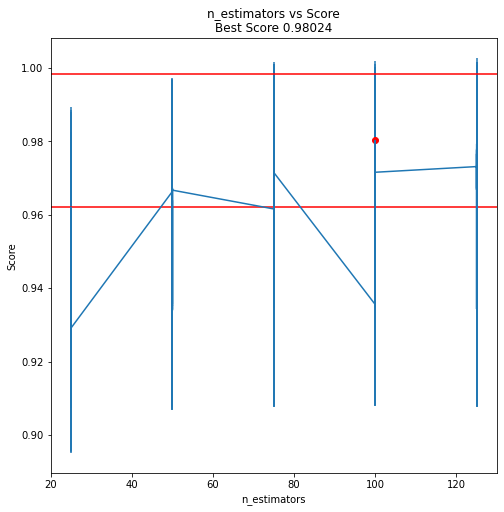

--- 27.797696828842163 seconds ---


In [4]:
# Grid Search XGBoost, no imbalanced classification
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import time
start_time = time.time()

xgb = XGBClassifier(eval_metric='logloss')

xg_tuning_params = {
    'eta': np.linspace(0.01, 0.1, 5, endpoint=True),
    'max_depth': [i for i in range(5, 8)],
    #'subsample':  np.linspace(0.5, 1.0, 2, endpoint=True),
    #'colsample_bytree': np.linspace(0.5, 1.0, 2, endpoint=True),
    #'colsample_bylevel': np.linspace(0.5, 1.0, 2, endpoint=True),
    #'colsample_bynode': np.linspace(0.5, 1.0, 2, endpoint=True),
    'n_estimators': [i*25 for i in range(1,6)],
    #'gamma':[i for i in range(0,2)],
    #'min_child_weight': np.linspace(1.0, 5.0, 2, endpoint=True),
    #'reg_lambda': list(range(1,2)),
    #'reg_alpha': np.linspace(0.01, 0.1, 2, endpoint=True)
}

gs = GridSearchCV(estimator=xgb, 
                  param_grid=xg_tuning_params, 
                  scoring='roc_auc', #or 'average_precision'
                  n_jobs=6, # for using how many parallel processing, dont set too many
                  cv=5)

# run gridearch
gs = gs.fit(X_train, y_train)
GridSearch_table_plot(gs, 'n_estimators', negative=False)
# 1st argument is the main gridsearchcv object,
# 2nd argument is the parameter that you like to draw in plot, required input
# 3rd argument is about should the sign of the score be reversed?
print("--- %s seconds ---" % (time.time() - start_time))
# it takes 33 seconds for about 100 combinations, cv=5, on my laptop

best parameters: {'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              gamma=None, gpu_id=None, importance_type=None,
              interaction_constraints=None, learning_rate=None,
              max_delta_step=None, max_depth=6, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=125,
              n_jobs=None, num_parallel_tree=None, predictor=None,
              random_state=0, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), 'classifier__eta': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 125, 'over__sampling_strategy': 0.1, 'under__sampling_strategy': 0.3}
best score:      0.98330 (+/-0.00805)
{'classifier': XGBClassifier(base_score=0.5, booster=

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__eta,param_classifier__max_depth,param_classifier__n_estimators,param_over__sampling_strategy,param_under__sampling_strategy,...,param_classifier__num_iterations,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1726,0.503502,0.041571,0.005917,5.770150e-03,"XGBClassifier(base_score=None, booster=None, c...",0.1,6,125,0.1,0.3,...,NaN,"{'classifier': XGBClassifier(base_score=None, ...",0.995344,0.980311,0.985283,0.970526,0.985046,0.983302,0.008052,1
1325,0.833387,0.169095,0.009373,7.652670e-03,"XGBClassifier(base_score=None, booster=None, c...",0.0775,6,100,0.1,0.1,...,NaN,"{'classifier': XGBClassifier(base_score=None, ...",0.991556,0.985243,0.987610,0.965120,0.980548,0.982015,0.009169,2
1839,1.051288,0.090719,0.006582,4.883636e-04,"XGBClassifier(base_score=None, booster=None, c...",0.1,7,100,0.5,0.9,...,NaN,"{'classifier': XGBClassifier(base_score=None, ...",0.992661,0.980271,0.985559,0.967842,0.981810,0.981629,0.008113,3
1108,0.939817,0.058419,0.003124,6.248665e-03,"XGBClassifier(base_score=None, booster=None, c...",0.055,7,125,0.3,0.7,...,NaN,"{'classifier': XGBClassifier(base_score=None, ...",0.989662,0.984691,0.983625,0.967172,0.982797,0.981589,0.007593,4
1850,1.236494,0.165924,0.006583,4.887334e-04,"XGBClassifier(base_score=None, booster=None, c...",0.1,7,125,0.1,0.1,...,NaN,"{'classifier': XGBClassifier(base_score=None, ...",0.995305,0.981771,0.981140,0.962792,0.986861,0.981574,0.010672,5
2704,0.185105,0.018223,0.004987,8.449576e-07,"LGBMClassifier(objective='binary', random_stat...",NaN,5,NaN,0.1,0.9,...,100,{'classifier': LGBMClassifier(objective='binar...,0.992227,0.987808,0.986782,0.963680,0.976918,0.981483,0.010211,6
1528,0.150320,0.012872,0.006715,5.059938e-03,"XGBClassifier(base_score=None, booster=None, c...",0.1,5,50,0.1,0.7,...,NaN,"{'classifier': XGBClassifier(base_score=None, ...",0.987216,0.983033,0.990767,0.961569,0.983685,0.981254,0.010224,7
1478,0.364625,0.012750,0.007380,4.882668e-04,"XGBClassifier(base_score=None, booster=None, c...",0.0775,7,125,0.1,0.7,...,NaN,"{'classifier': XGBClassifier(base_score=None, ...",0.990491,0.988202,0.987374,0.956676,0.982008,0.980950,0.012452,8
3579,0.222866,0.027714,0.004977,7.707086e-03,"LGBMClassifier(objective='binary', random_stat...",NaN,6,NaN,0.1,0.9,...,100,{'classifier': LGBMClassifier(objective='binar...,0.988281,0.989307,0.976207,0.967606,0.982363,0.980753,0.008074,9
1463,1.081907,0.045853,0.006582,4.884805e-04,"XGBClassifier(base_score=None, booster=None, c...",0.0775,7,100,0.5,0.7,...,NaN,"{'classifier': XGBClassifier(base_score=None, ...",0.991793,0.985125,0.986308,0.960227,0.980153,0.980721,0.010895,10


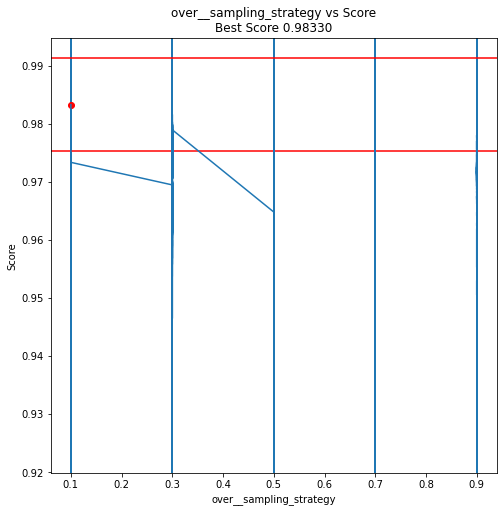

--- 995.3834366798401 seconds ---


In [5]:
from imblearn.pipeline import Pipeline 
# important: You should import make_pipeline from imblearn.pipeline 
# and not from sklearn.pipeline: 
# make_pipeline from sklearn needs the transformers 
# to implement fit and transform methods but SMOTE does not implement transform.
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb # we will use 2 best algorithms to classify

# turn off warnings
import warnings
warnings.filterwarnings("ignore")

import time
start_time = time.time()

# you can mix and matach with any oversampling and undersampling methods
over = SMOTE(sampling_strategy=0.1) 
under = RandomUnderSampler(sampling_strategy=0.5)

# start the pipeline specifications
xgb = XGBClassifier(eval_metric='logloss', random_state=0)
lgb=lgb.LGBMClassifier(objective='binary', random_state=0)

# pipeline
steps = [('over', over), ('under', under), ('classifier', xgb)]
pipe = Pipeline(steps=steps)

#
param_grid = [
  {'classifier': [xgb],
   'over__sampling_strategy': [0.1, 0.3, 0.5, 0.7, 0.9],
   'under__sampling_strategy': [0.1, 0.3, 0.5, 0.7, 0.9],
   'classifier__eta': np.linspace(0.01, 0.1, 5, endpoint=True),
   'classifier__max_depth': [i for i in range(5, 8)],
   'classifier__n_estimators': [i*25 for i in range(1,6)]
   },
   {'classifier': [lgb],
   'over__sampling_strategy': [0.1, 0.3, 0.5, 0.7, 0.9],
   'under__sampling_strategy': [0.1, 0.3, 0.5, 0.7, 0.9],
   'classifier__learning_rate': np.linspace(0.01, 0.1, 5, endpoint=True),
   'classifier__max_depth': [i for i in range(5, 8)],
   'classifier__num_iterations': [i*25 for i in range(1,6)]
   }
]

gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid, 
                  scoring='roc_auc', # or 'average_precision' which means PRC_AUC
                  n_jobs=5, # for using how many parallel processing, dont set too many
                  cv=5)

# run gridearch
gs = gs.fit(X_train, y_train)
GridSearch_table_plot(gs, 'over__sampling_strategy', negative=False)

print("--- %s seconds ---" % (time.time() - start_time))
# it takes 20 minutes on my laptop.
# winner is XGBoost with best score 0.98258 (+/-0.00920)